In [1]:
import os
import sys
import re
import glob
import h5py

os.chdir('/home/yajatyadav/multitask_reinforcement_learning/multitask_RL')
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

# # Add libero path before importing libero_utils
# libero_path = '/home/yajatyadav/multitask_reinforcement_learning/multitask_RL/libero/libero'
# if libero_path not in sys.path:
#     sys.path.insert(0, libero_path)

from envs.env_utils import make_env_and_datasets

In [2]:
def extract_libero_task_name(fp):
    fp = os.path.basename(fp).split('.')[0][:-5]
    if "SCENE" in fp:
        match = re.search(r'\d+', fp)
        fp = fp[match.end() + 1:]
    print(f'TASK NAME IS: {fp}')        
    return fp

from utils.datasets import Dataset
# handle dataset
def process_train_dataset(ds):
    """
    Process the train dataset to 
        - handle dataset proportion
        - handle sparse reward
        - convert to action chunked dataset
    """

    ds = Dataset.create(**ds)
    
    print(f"main.py:Translating dataset rewards by -1")
    penalty_rewards = ds["rewards"] - 1.0
    ds_dict = {k: v for k, v in ds.items()}
    ds_dict["rewards"] = penalty_rewards
    ds = Dataset.create(**ds_dict)
    
    # print(f"main.py: Sparsifiying rewards by setting all non-zero rewards to -1")
    # # Create a new dataset with modified rewards instead of trying to modify the frozen one
    # sparse_rewards = (ds["rewards"] != 0.0) * -1.0
    # ds_dict = {k: v for k, v in ds.items()}
    # ds_dict["rewards"] = sparse_rewards
    # ds = Dataset.create(**ds_dict)
    return ds

In [4]:
# load in 2 demo trajectories

suite_dir = '/home/yajatyadav/multitask_reinforcement_learning/datasets/raw_libero/LIBERO_90'
scene_pattern = 'LIVING_ROOM_SCENE1_*_demo.hdf5'

keys_to_load = ['agentview_rgb', 'eye_in_hand_rgb', 'proprio', 'language']
filepaths = glob.glob(os.path.join(suite_dir, scene_pattern))

ENV_NAME = 'libero_90-living_room_scene1'
TASK_NAME = 'pick_up_the_alphabet_soup_and_put_it_in_the_basket|pick_up_the_ketchup_and_put_it_in_the_basket'

task_to_datasets = {}

for task_name in TASK_NAME.split('|'):
    env, eval_env, train_dataset, val_dataset, names_to_return = make_env_and_datasets(
    ENV_NAME,
    task_name,
    'none',
    num_parallel_envs=5,
    keys_to_load=keys_to_load,
    use_hardcoded_eval_envs=False,
    demo_nums_to_use_per_task=[5],
    )
    task_to_datasets[task_name] = process_train_dataset(train_dataset)

TODO(YY): Normalization path not implemented for libero_90-living_room_scene1-pick_up_the_alphabet_soup_and_put_it_in_the_basket
evaluation environment will return keys:  {'agentview_image', 'robot0_eye_in_hand_image', 'language', 'proprio'}
all_tasks: ['pick_up_the_alphabet_soup_and_put_it_in_the_basket']
suites: ['libero_90'], scenes: ['living_room_scene1']
All possible envs, sorted alphabetically: there are 1 total envs
 len(envs_to_eval)=1 Environments to evaluate: ['libero_90-LIVING_ROOM_SCENE1_pick_up_the_alphabet_soup_and_put_it_in_the_basket']
all_tasks: ['pick_up_the_alphabet_soup_and_put_it_in_the_basket']
suites: ['libero_90'], scenes: ['living_room_scene1']
🤪🤪🤪 all_libero_env_names: {'libero_90': ['libero_90-LIVING_ROOM_SCENE1_pick_up_the_alphabet_soup_and_put_it_in_the_basket']}
🤪🤪🤪 distinct_scenes: {'libero_90': ['LIVING_ROOM_SCENE1']}
😈😈😈 target_task_name='pick_up_the_alphabet_soup_and_put_it_in_the_basket'
😎😎😎 ONLY using [5] demos for target_task: pick_up_the_alphabet_s

In [6]:
from agents.acifql import get_config
from agents import agents
from utils.flax_utils import restore_agent_actor_critic_separately, restore_agent_with_file

agent_config = get_config()
encoder = 'combined_encoder_small'
seed = 0
n = 16
horizon_length = 5
agent_config['encoder'] = encoder
agent_config['num_samples'] = n
agent_config['horizon_length'] = horizon_length

agent_class_str = 'acifql'
agent_class = agents[agent_class_str]

example_batch = train_dataset.sample_sequence(1, sequence_length=horizon_length, discount=0.99)
# agent = restore_agent_actor_critic_separately(agent, actor_restore_path, critic_restore_path)

In [8]:
root_dir = '/home/yajatyadav/multitask_reinforcement_learning/multitask_RL/exp/multitask_RL'
onetask_critic_no_aug_ckpt = 'instruction_following_Q/libero_90-living_room_scene1/libero90_livingroomscene1_singletask_none_augmentation_IMAGE_sd00020251226_214011/params_125000.pkl'
two_task_critic_no_aug_ckpt = 'instruction_following_Q/libero_90-living_room_scene1/libero90_livingroomscene1_twotask_none_augmentation_IMAGE_sd00020251226_214200/params_125000.pkl'
onetask_critic_aug_one_other_task_ckpt = 'instruction_following_Q/libero_90-living_room_scene1/libero90_livingroomscene1_singletask_one_other_task__augmentation_IMAGE_sd00020251226_215816/params_250000.pkl'
two_task_critic_aug_each_other_task_ckpt = 'instruction_following_Q/libero_90-living_room_scene1/libero90_livingroomscene1_twotask_augment_each_other_IMAGE_sd00020251226_215758/params_250000.pkl'

critic_ckpts = [onetask_critic_no_aug_ckpt, two_task_critic_no_aug_ckpt, onetask_critic_aug_one_other_task_ckpt, two_task_critic_aug_each_other_task_ckpt]

agents = {}
for critic_ckpt in critic_ckpts:
    print(f"creating agent")
    agent = agent_class.create(seed, example_batch['observations'], example_batch['actions'], agent_config)
    label = (''.join(critic_ckpt.split('/')[-2:])).split('.')[0]
    print(f"restoring agent with {label}")
    agent_restore_path = os.path.join(root_dir, critic_ckpt)
    agent = restore_agent_with_file(agent, agent_restore_path)
    agents[label] = agent

creating agent
restoring agent with libero90_livingroomscene1_singletask_none_augmentation_IMAGE_sd00020251226_214011params_125000
Restored from /home/yajatyadav/multitask_reinforcement_learning/multitask_RL/exp/multitask_RL/instruction_following_Q/libero_90-living_room_scene1/libero90_livingroomscene1_singletask_none_augmentation_IMAGE_sd00020251226_214011/params_125000.pkl
creating agent
restoring agent with libero90_livingroomscene1_twotask_none_augmentation_IMAGE_sd00020251226_214200params_125000
Restored from /home/yajatyadav/multitask_reinforcement_learning/multitask_RL/exp/multitask_RL/instruction_following_Q/libero_90-living_room_scene1/libero90_livingroomscene1_twotask_none_augmentation_IMAGE_sd00020251226_214200/params_125000.pkl
creating agent
restoring agent with libero90_livingroomscene1_singletask_one_other_task__augmentation_IMAGE_sd00020251226_215816params_250000
Restored from /home/yajatyadav/multitask_reinforcement_learning/multitask_RL/exp/multitask_RL/instruction_fo

In [19]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


def plot_Q_V_for_agent(agent):
    plot_data = {}
    for task_name, train_dataset in task_to_datasets.items():
        print(f"processing {task_name}")
        traj_state_values = []
        traj_q_values = []
        traj_len = len(train_dataset['actions'])

        for i in tqdm(range(traj_len)):
            if i < traj_len - horizon_length:
                transition = train_dataset.sample_sequence(1, sequence_length=horizon_length, discount=0.99, idxs_to_use=np.array([i,]))
            else:
                transition = train_dataset.sample_sequence(1, sequence_length=traj_len - i, discount=0.99, idxs_to_use=np.array([i,]))
            
            # can go right to the end for V(s) but not Q(s,a) as actions are chunked
            v = agent.network.select('value')(transition['observations'])
            traj_state_values.append(v)

            if i < traj_len - horizon_length:            
                batch_actions = np.reshape(transition['actions'], (transition['actions'].shape[0], -1))
                q1, q2 = agent.network.select('critic')(transition['observations'], actions=batch_actions)
                q = np.minimum(q1, q2)
                traj_q_values.append(q)

        traj_state_values = np.concatenate(traj_state_values, axis=0)
        traj_q_values = np.concatenate(traj_q_values, axis=0)

        # instead of plotting, return the values needed for plotting
        plot_data[task_name] = {
            'traj_state_values': traj_state_values,
            'traj_q_values': traj_q_values,
        }

    return plot_data

In [ ]:
for label, agent in agents.items():
    print(f"plotting for {label} ")
    plot_data = plot_Q_V_for_agent(agent)

    for task_name, data in plot_data.items():
        traj_state_values = data['traj_state_values']
        traj_q_values = data['traj_q_values']
        # plot traj_state_values
        plt.plot(traj_state_values, label=label)
        plt.title('V(s) for trajectory of task: ' + task_name)
        plt.legend()
        plt.show()

        # plot traj_q_values
        plt.plot(traj_q_values, label=label)
        plt.title('Q(s, a) for trajectory of task: ' + task_name)
        plt.legend()
        plt.show()

In [ ]:
import jax
import jax.numpy as jnp

def plot_Q_heatmap_for_agent(agent):
    plot_data = {}
    for task_name, train_dataset in task_to_datasets.items():
        print(f"processing {task_name}")
        traj_len = len(train_dataset['actions'])


        all_observations, all_actions = [], []
        for i in tqdm(range(traj_len - horizon_length)):
            for j in range(traj_len - horizon_length):
                transition_i = train_dataset.sample_sequence(1, sequence_length=5, discount=0.99, idxs_to_use=np.array([i,]))
                transition_j = train_dataset.sample_sequence(1, sequence_length=5, discount=0.99, idxs_to_use=np.array([j,]))

                actions_to_use = transition_j['actions']
                batch_actions = np.reshape(actions_to_use, (actions_to_use.shape[0], -1))


                obs = transition_i['observations']
                act = batch_actions

                all_observations.append(obs)
                all_actions.append(act)
        
        print(f"stacking everything")
        stacked_obs = jax.tree_util.tree_map(lambda *xs: jnp.concatenate(xs, axis=0), *all_observations)
        stacked_acts = np.concatenate(all_actions, axis=0)

        def process_in_batches(agent, stacked_obs, stacked_acts, batch_size=256):
            total_size = jax.tree_util.tree_leaves(stacked_obs)[0].shape[0]
            num_batches = (total_size + batch_size - 1) // batch_size
            
            all_q_values = []        
            for start_idx in tqdm(range(0, total_size, batch_size), 
                                        total=num_batches, 
                                        desc="Computing Q-values"):
                end_idx = min(start_idx + batch_size, total_size)
                
                batch_obs = jax.tree_util.tree_map(lambda x: x[start_idx:end_idx], stacked_obs)
                batch_acts = stacked_acts[start_idx:end_idx]
                
                q1, q2 = agent.network.select('critic')(batch_obs, actions=batch_acts)
                q = jnp.minimum(q1, q2)
                
                all_q_values.append(q)
            
            return jnp.concatenate(all_q_values, axis=0)

        q_vals = process_in_batches(agent, stacked_obs, stacked_acts, batch_size=256)
        q_vals = q_vals.reshape(traj_len - horizon_length, traj_len - horizon_length)
        plot_data[task_name] = q_vals
    return plot_data


In [ ]:
for label, agent in agents.items():
    print(f"plotting for {label} ")
    plot_data = plot_Q_heatmap_for_agent(agent)

    for task_name, q_vals in plot_data.items():
        plt.imshow(q_vals)
        plt.title('Q(s, a) for all trajectory state/actions ' + task_name)
        plt.colorbar(label=label)
        plt.legend()
        plt.show()

# On the augmented Q, compute Q(s, a, t) with intentionally mislabeled t

In [58]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


def plot_Q_V_for_agent_augmented(agent):
    plot_data = {}

    task_lang_combos = []
    for task_name in task_to_datasets.keys():
        for task_name_other in task_to_datasets.keys():
            task_lang_combos.append((task_name, task_name_other))


    for task_name, relabeled_task_name in task_lang_combos:
        print(f"processing {task_name} and {relabeled_task_name}")
        train_dataset = task_to_datasets[task_name]
        traj_len = len(train_dataset['actions'])
        traj_state_values = []
        traj_q_values = []


        relabeled_task_dataset = task_to_datasets[relabeled_task_name]
        relabeled_task_sample_transition = relabeled_task_dataset.sample_sequence(1, sequence_length=5, discount=0.99, idxs_to_use=np.array([0,]))
        relabeled_task_lang_embedding = relabeled_task_sample_transition['observations']['language']

        train_dataset_sample_transition = train_dataset.sample_sequence(1, sequence_length=5, discount=0.99, idxs_to_use=np.array([0,]))
        train_dataset_lang_embedding = train_dataset_sample_transition['observations']['language']
        print(f"original_task_lang_embedding: 1 is at pos: {np.where(train_dataset_lang_embedding[0] == 1)}")
        print(f"relabeled_task_lang_embedding: 1 is at pos: {np.where(relabeled_task_lang_embedding[0] == 1)}")

        for i in tqdm(range(traj_len)):
            if i < traj_len - horizon_length:
                transition = train_dataset.sample_sequence(1, sequence_length=horizon_length, discount=0.99, idxs_to_use=np.array([i,]))
            else:
                transition = train_dataset.sample_sequence(1, sequence_length=traj_len - i, discount=0.99, idxs_to_use=np.array([i,]))

            # relabel transition['observations']['language'] to relabeled_task_lang_embedding
            transition['observations']['language'] = relabeled_task_lang_embedding
            
            # can go right to the end for V(s) but not Q(s,a) as actions are chunked
            v = agent.network.select('value')(transition['observations'])
            traj_state_values.append(v)

            if i < traj_len - horizon_length:            
                batch_actions = np.reshape(transition['actions'], (transition['actions'].shape[0], -1))
                q1, q2 = agent.network.select('critic')(transition['observations'], actions=batch_actions)
                q = np.minimum(q1, q2)
                traj_q_values.append(q)

        traj_state_values = np.concatenate(traj_state_values, axis=0)
        traj_q_values = np.concatenate(traj_q_values, axis=0)

        # instead of plotting, return the values needed for plotting
        plot_data[(task_name, relabeled_task_name)] = {
            'traj_state_values': traj_state_values,
            'traj_q_values': traj_q_values,
        }

    return plot_data

plotting for libero90_livingroomscene1_singletask_none_augmentation_IMAGE_sd00020251226_214011params_125000
processing pick_up_the_alphabet_soup_and_put_it_in_the_basket and pick_up_the_alphabet_soup_and_put_it_in_the_basket
original_task_lang_embedding: 1 is at pos: (array([12]),)
relabeled_task_lang_embedding: 1 is at pos: (array([12]),)


100%|██████████| 153/153 [00:20<00:00,  7.42it/s]


processing pick_up_the_alphabet_soup_and_put_it_in_the_basket and pick_up_the_ketchup_and_put_it_in_the_basket
original_task_lang_embedding: 1 is at pos: (array([12]),)
relabeled_task_lang_embedding: 1 is at pos: (array([43]),)


100%|██████████| 153/153 [00:20<00:00,  7.52it/s]


processing pick_up_the_ketchup_and_put_it_in_the_basket and pick_up_the_alphabet_soup_and_put_it_in_the_basket
original_task_lang_embedding: 1 is at pos: (array([43]),)
relabeled_task_lang_embedding: 1 is at pos: (array([12]),)


100%|██████████| 169/169 [00:22<00:00,  7.42it/s]


processing pick_up_the_ketchup_and_put_it_in_the_basket and pick_up_the_ketchup_and_put_it_in_the_basket
original_task_lang_embedding: 1 is at pos: (array([43]),)
relabeled_task_lang_embedding: 1 is at pos: (array([43]),)


100%|██████████| 169/169 [00:22<00:00,  7.42it/s]


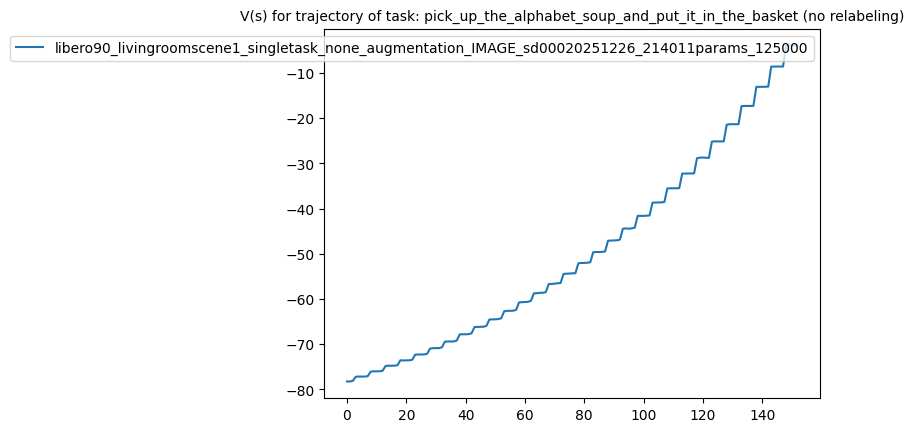

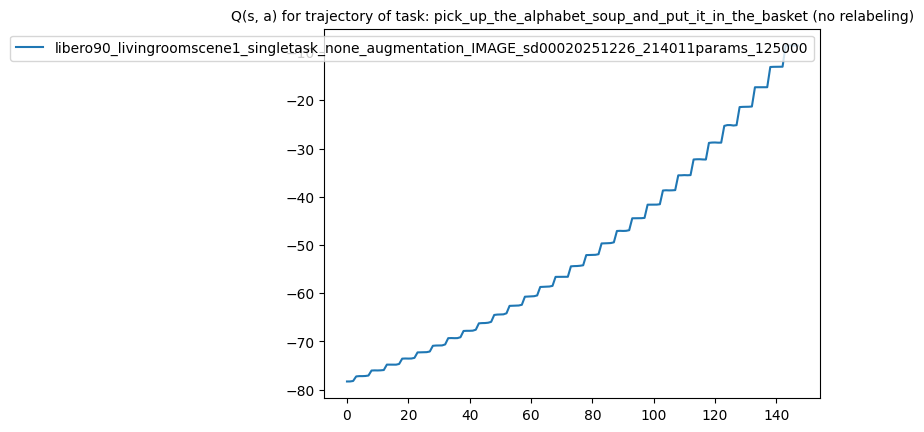

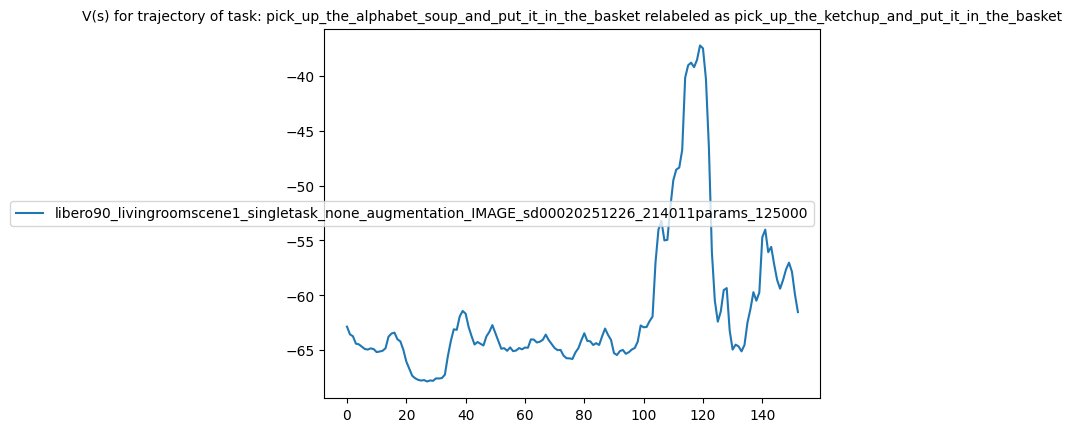

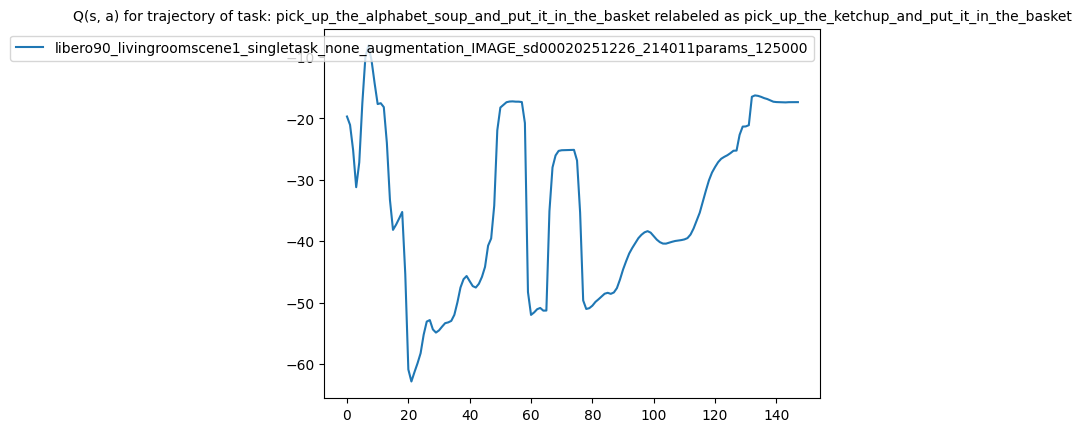

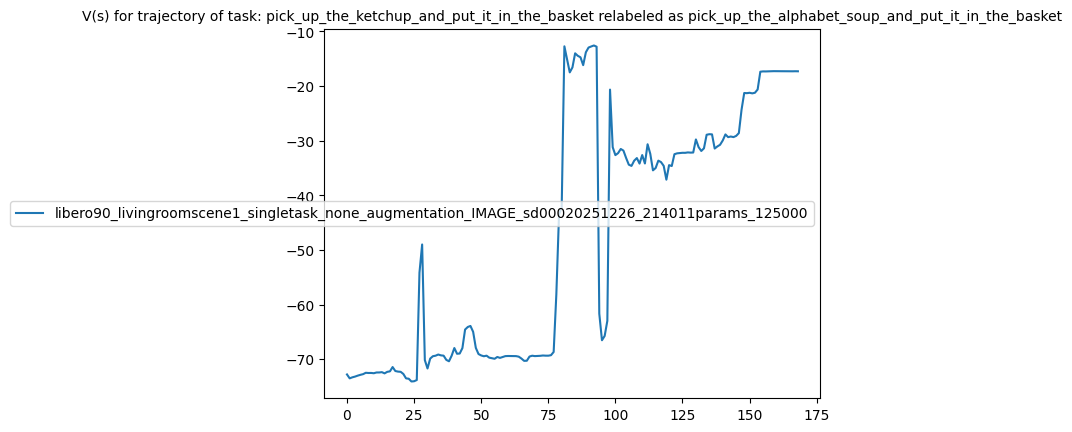

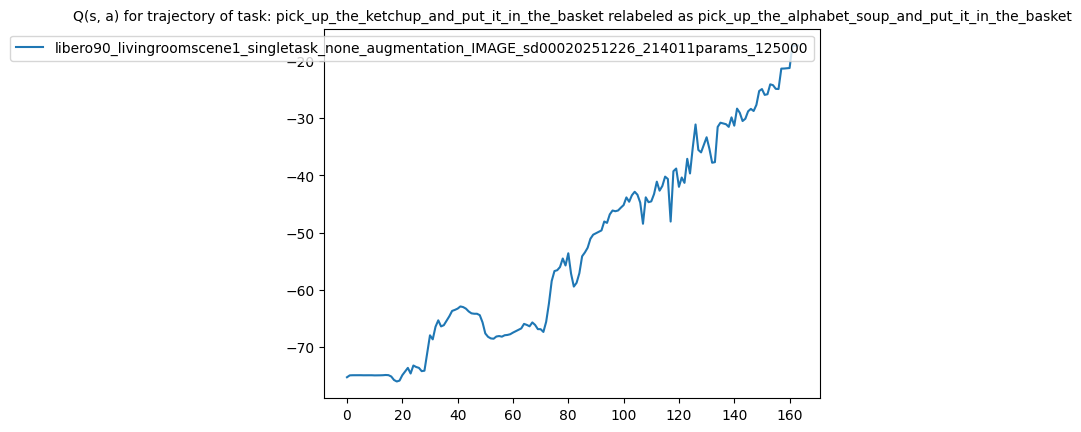

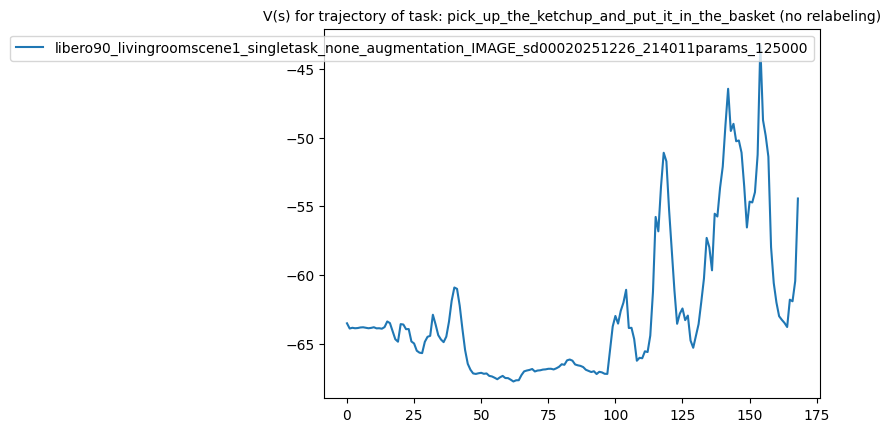

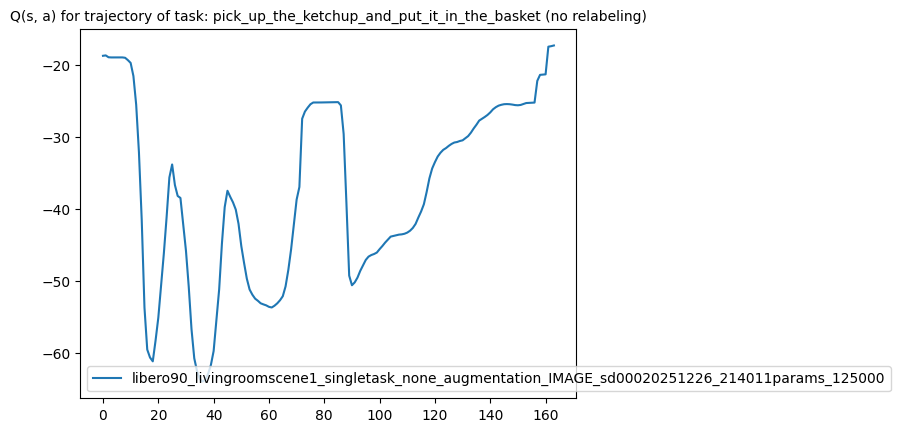

plotting for libero90_livingroomscene1_twotask_none_augmentation_IMAGE_sd00020251226_214200params_125000
processing pick_up_the_alphabet_soup_and_put_it_in_the_basket and pick_up_the_alphabet_soup_and_put_it_in_the_basket
original_task_lang_embedding: 1 is at pos: (array([12]),)
relabeled_task_lang_embedding: 1 is at pos: (array([12]),)


100%|██████████| 153/153 [00:20<00:00,  7.39it/s]


processing pick_up_the_alphabet_soup_and_put_it_in_the_basket and pick_up_the_ketchup_and_put_it_in_the_basket
original_task_lang_embedding: 1 is at pos: (array([12]),)
relabeled_task_lang_embedding: 1 is at pos: (array([43]),)


100%|██████████| 153/153 [00:21<00:00,  7.26it/s]


processing pick_up_the_ketchup_and_put_it_in_the_basket and pick_up_the_alphabet_soup_and_put_it_in_the_basket
original_task_lang_embedding: 1 is at pos: (array([43]),)
relabeled_task_lang_embedding: 1 is at pos: (array([12]),)


100%|██████████| 169/169 [00:23<00:00,  7.28it/s]


processing pick_up_the_ketchup_and_put_it_in_the_basket and pick_up_the_ketchup_and_put_it_in_the_basket
original_task_lang_embedding: 1 is at pos: (array([43]),)
relabeled_task_lang_embedding: 1 is at pos: (array([43]),)


100%|██████████| 169/169 [00:23<00:00,  7.34it/s]


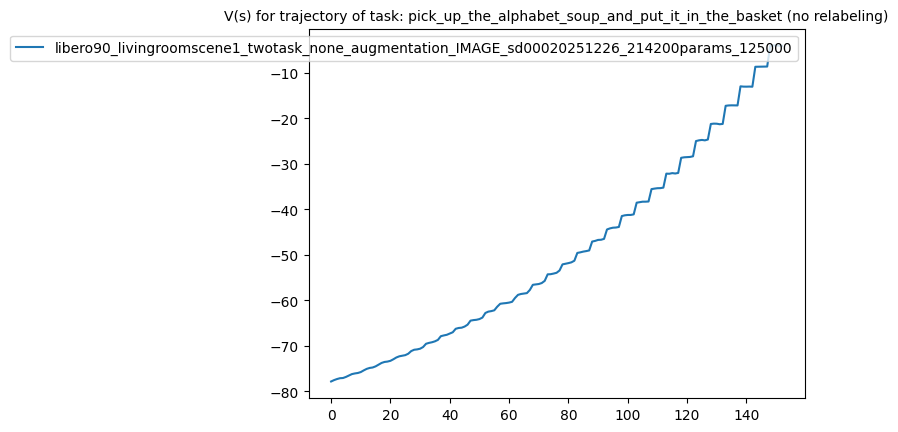

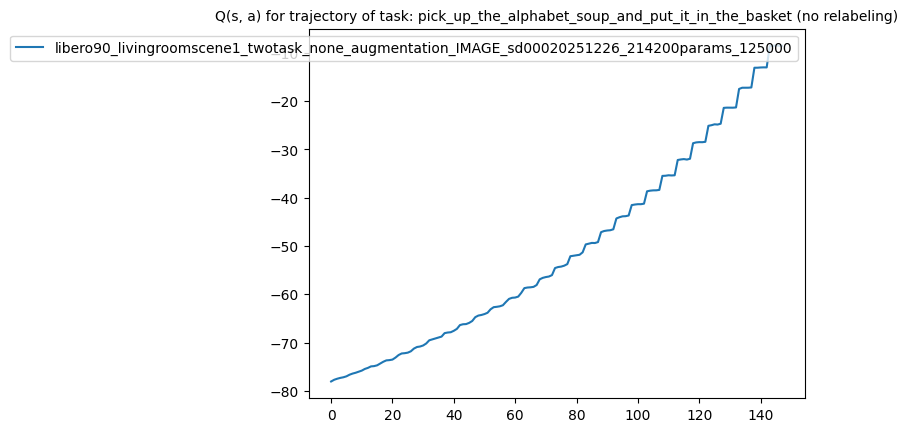

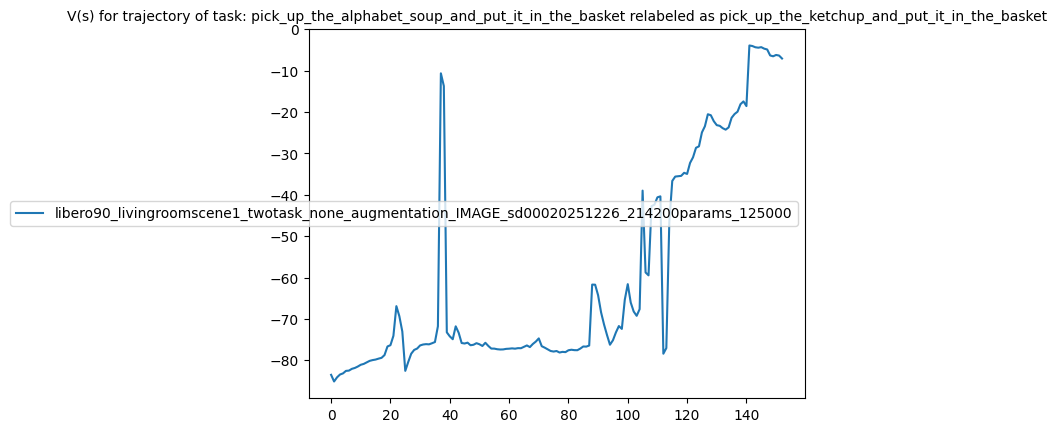

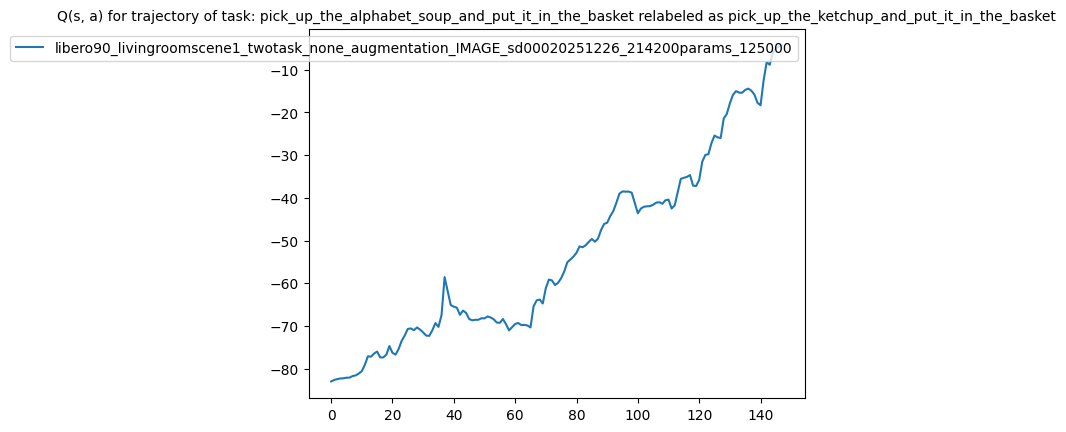

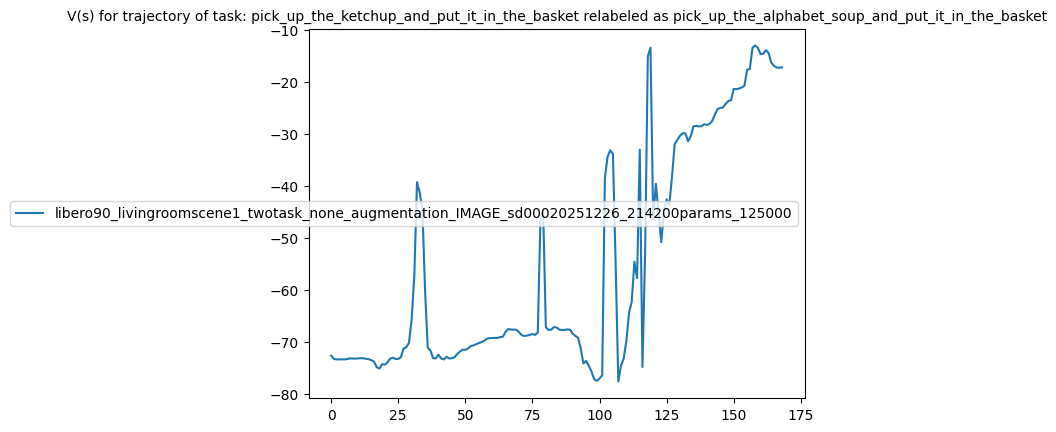

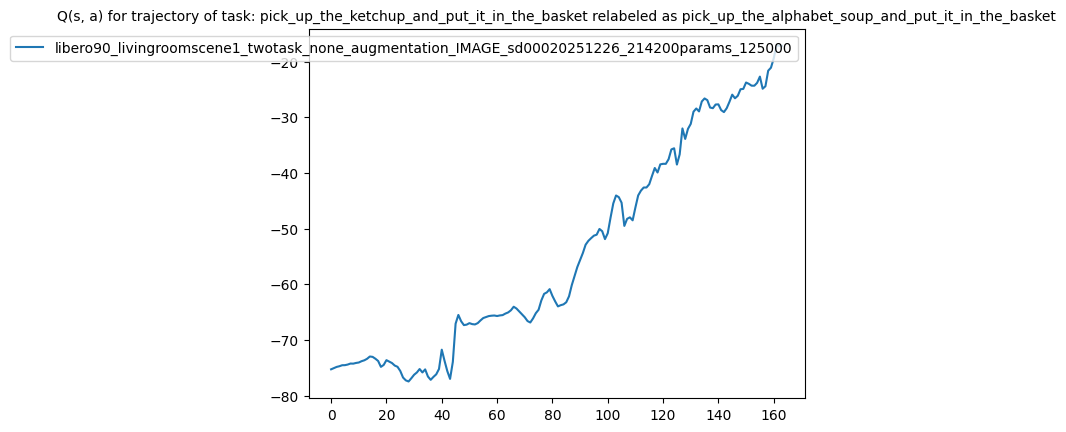

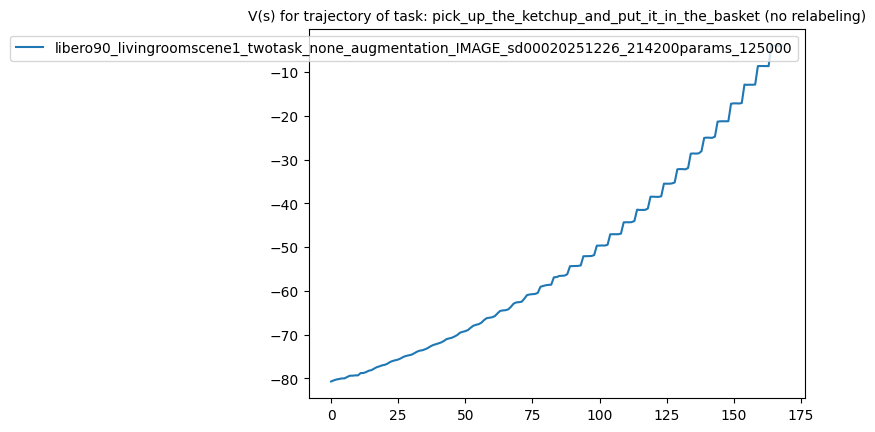

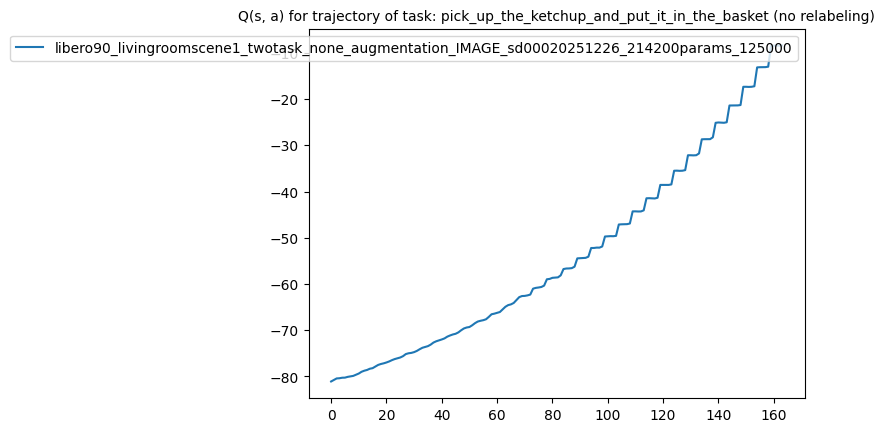

plotting for libero90_livingroomscene1_singletask_one_other_task__augmentation_IMAGE_sd00020251226_215816params_250000
processing pick_up_the_alphabet_soup_and_put_it_in_the_basket and pick_up_the_alphabet_soup_and_put_it_in_the_basket
original_task_lang_embedding: 1 is at pos: (array([12]),)
relabeled_task_lang_embedding: 1 is at pos: (array([12]),)


100%|██████████| 153/153 [00:20<00:00,  7.38it/s]


processing pick_up_the_alphabet_soup_and_put_it_in_the_basket and pick_up_the_ketchup_and_put_it_in_the_basket
original_task_lang_embedding: 1 is at pos: (array([12]),)
relabeled_task_lang_embedding: 1 is at pos: (array([43]),)


100%|██████████| 153/153 [00:20<00:00,  7.36it/s]


processing pick_up_the_ketchup_and_put_it_in_the_basket and pick_up_the_alphabet_soup_and_put_it_in_the_basket
original_task_lang_embedding: 1 is at pos: (array([43]),)
relabeled_task_lang_embedding: 1 is at pos: (array([12]),)


100%|██████████| 169/169 [00:22<00:00,  7.41it/s]


processing pick_up_the_ketchup_and_put_it_in_the_basket and pick_up_the_ketchup_and_put_it_in_the_basket
original_task_lang_embedding: 1 is at pos: (array([43]),)
relabeled_task_lang_embedding: 1 is at pos: (array([43]),)


100%|██████████| 169/169 [00:22<00:00,  7.49it/s]


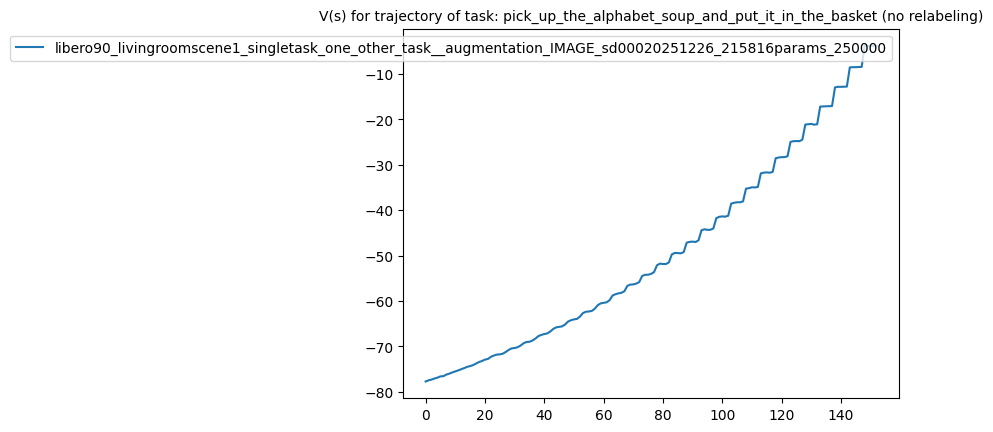

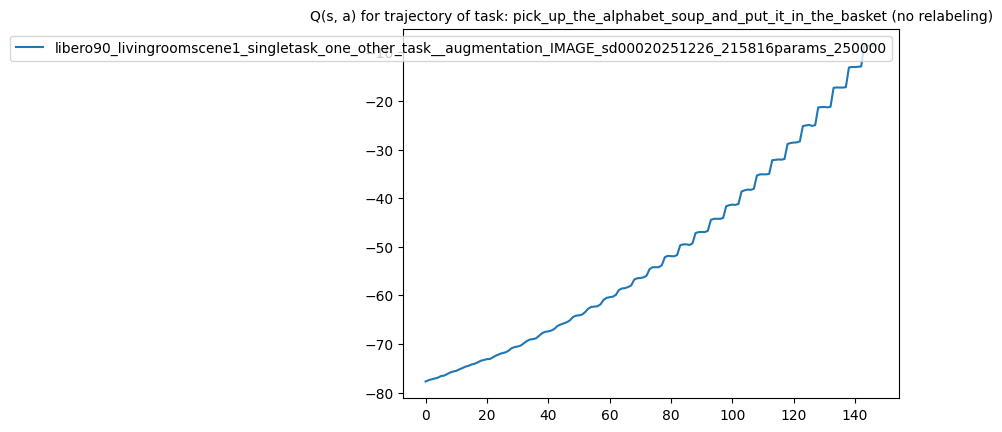

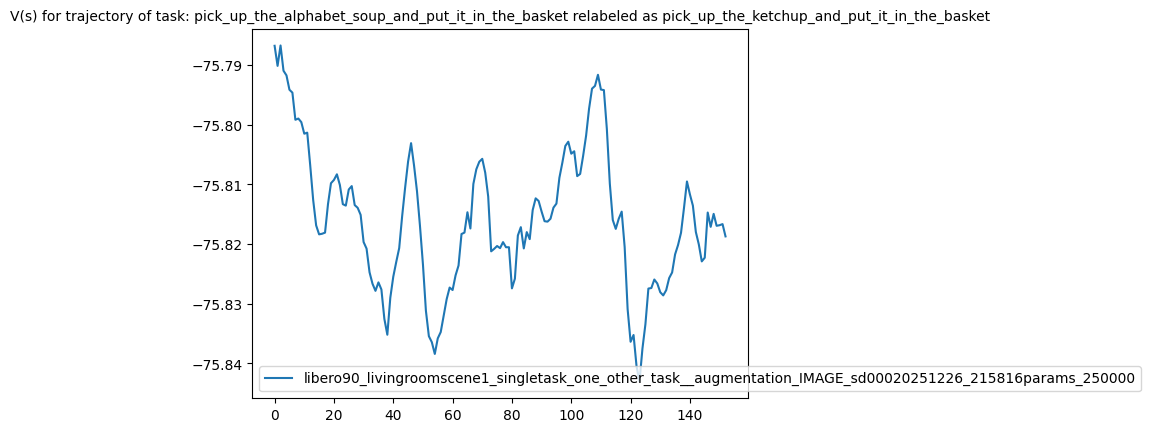

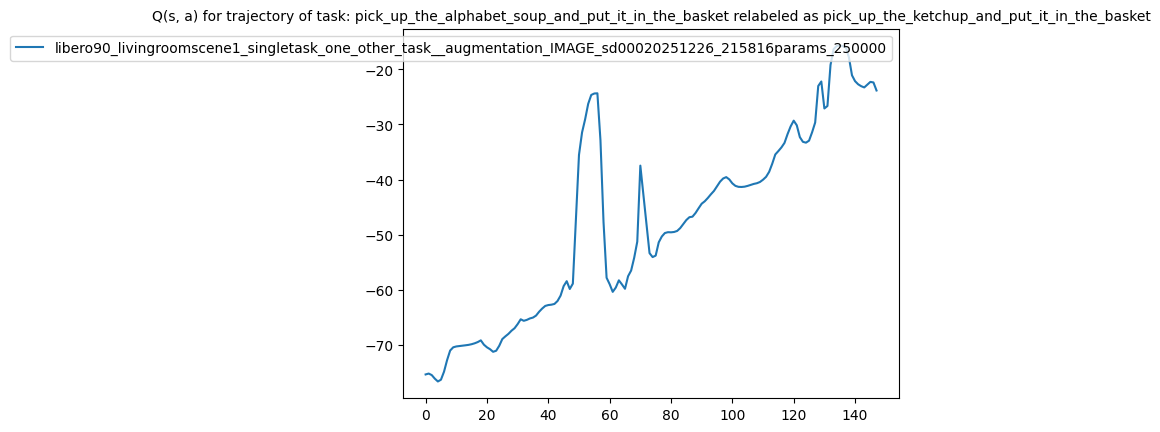

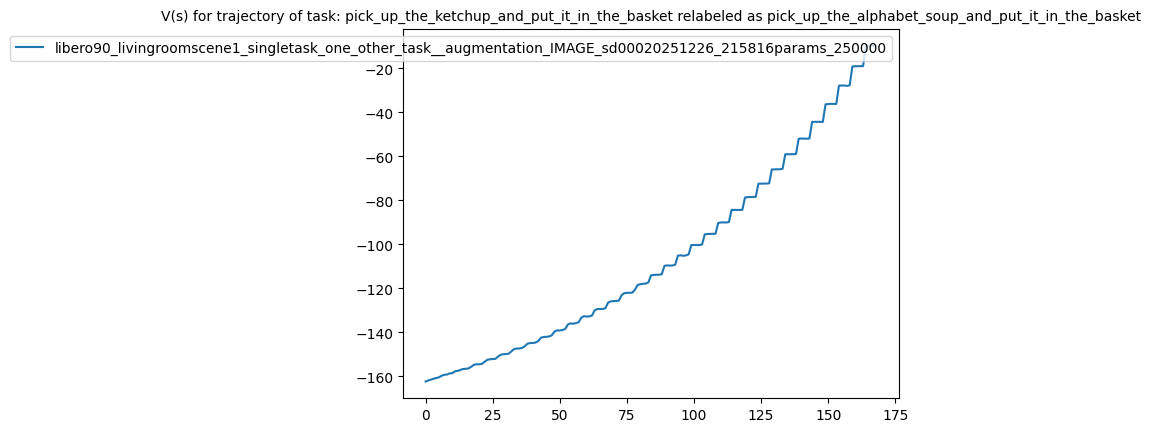

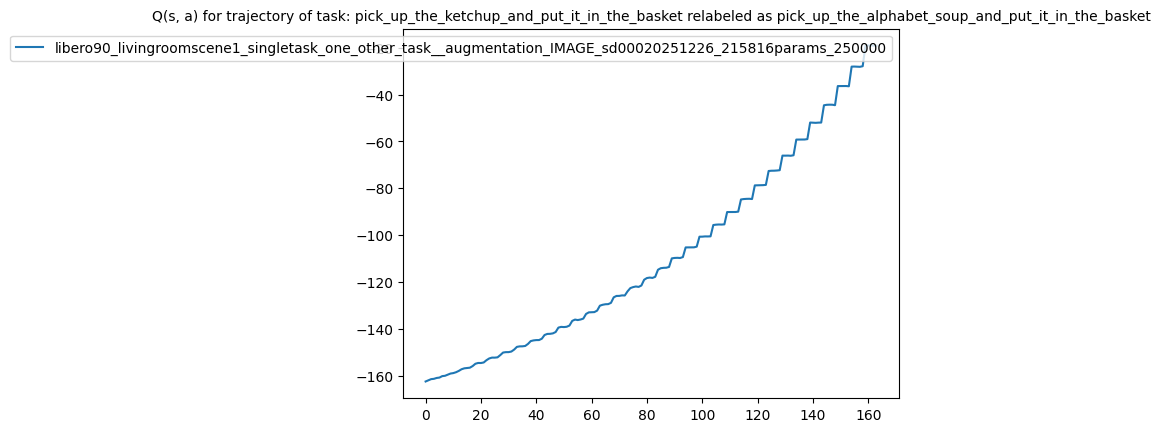

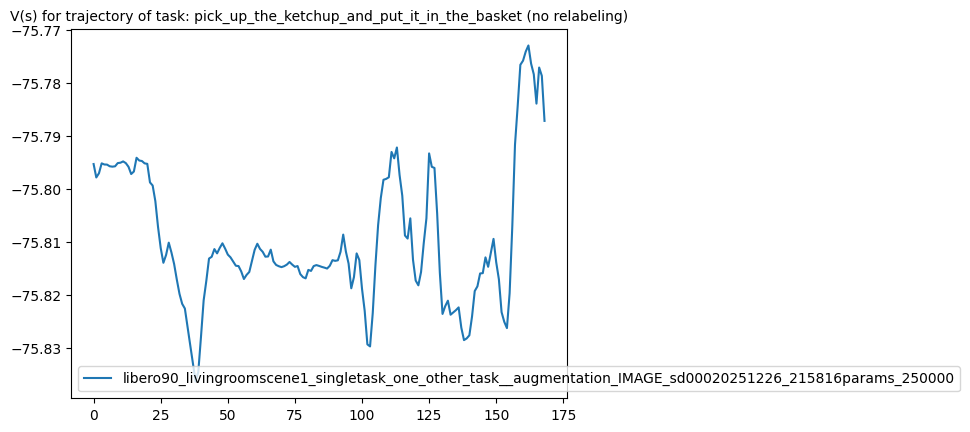

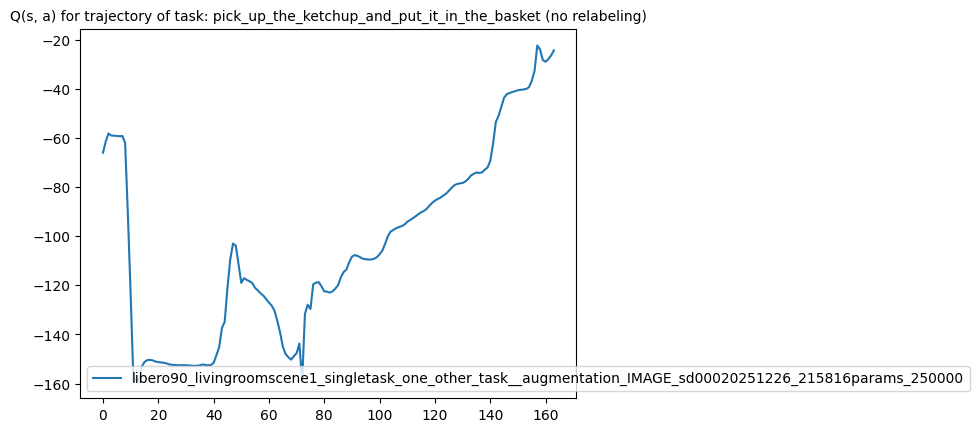

plotting for libero90_livingroomscene1_twotask_augment_each_other_IMAGE_sd00020251226_215758params_250000
processing pick_up_the_alphabet_soup_and_put_it_in_the_basket and pick_up_the_alphabet_soup_and_put_it_in_the_basket
original_task_lang_embedding: 1 is at pos: (array([12]),)
relabeled_task_lang_embedding: 1 is at pos: (array([12]),)


100%|██████████| 153/153 [00:20<00:00,  7.40it/s]


processing pick_up_the_alphabet_soup_and_put_it_in_the_basket and pick_up_the_ketchup_and_put_it_in_the_basket
original_task_lang_embedding: 1 is at pos: (array([12]),)
relabeled_task_lang_embedding: 1 is at pos: (array([43]),)


100%|██████████| 153/153 [00:20<00:00,  7.42it/s]


processing pick_up_the_ketchup_and_put_it_in_the_basket and pick_up_the_alphabet_soup_and_put_it_in_the_basket
original_task_lang_embedding: 1 is at pos: (array([43]),)
relabeled_task_lang_embedding: 1 is at pos: (array([12]),)


100%|██████████| 169/169 [00:23<00:00,  7.29it/s]


processing pick_up_the_ketchup_and_put_it_in_the_basket and pick_up_the_ketchup_and_put_it_in_the_basket
original_task_lang_embedding: 1 is at pos: (array([43]),)
relabeled_task_lang_embedding: 1 is at pos: (array([43]),)


100%|██████████| 169/169 [00:22<00:00,  7.37it/s]


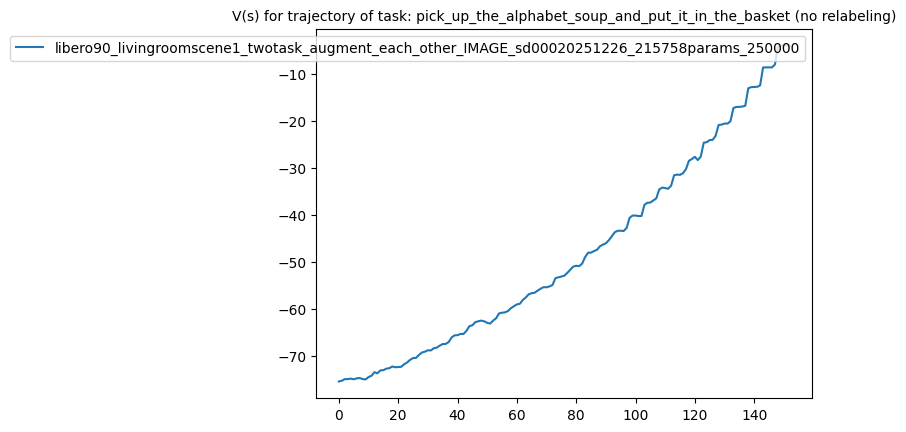

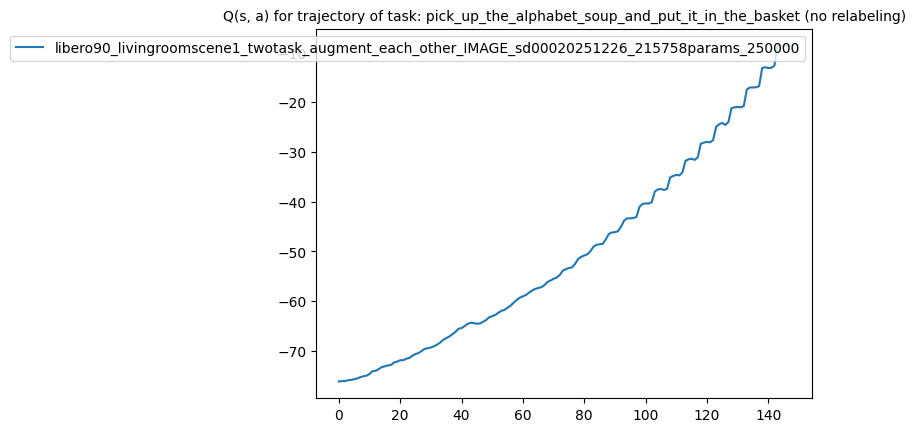

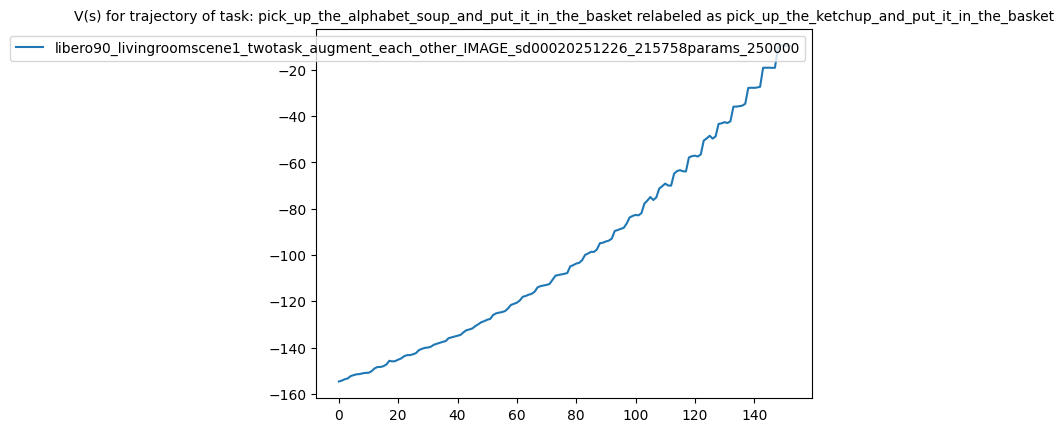

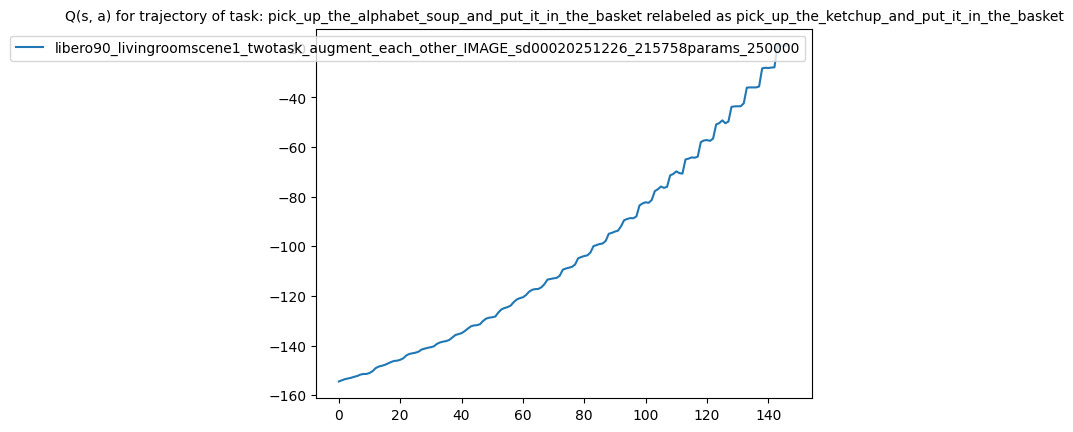

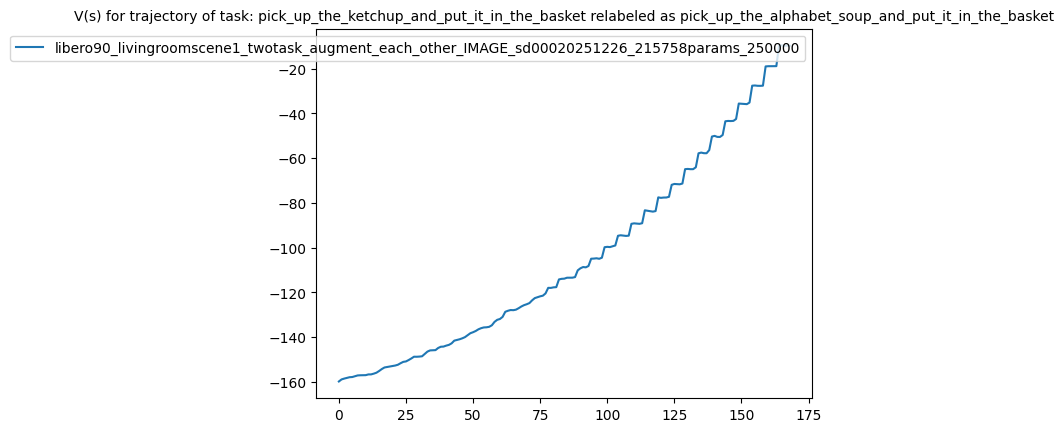

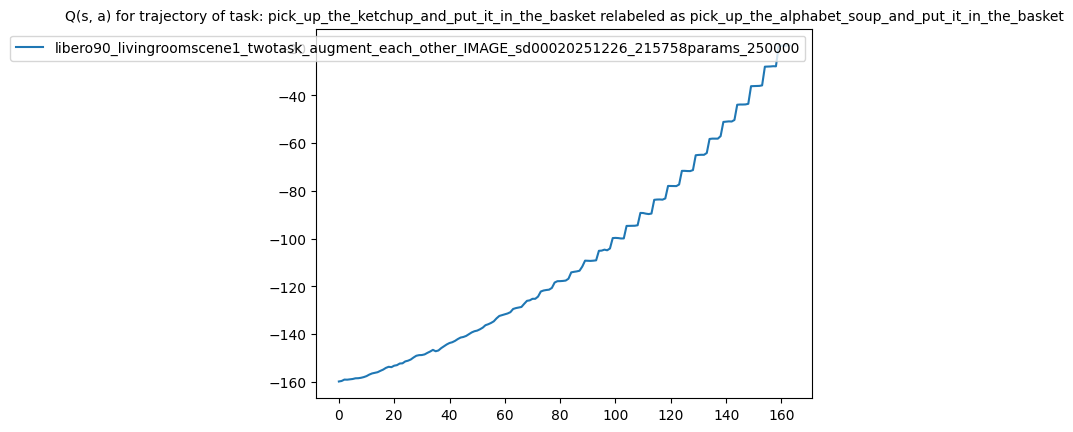

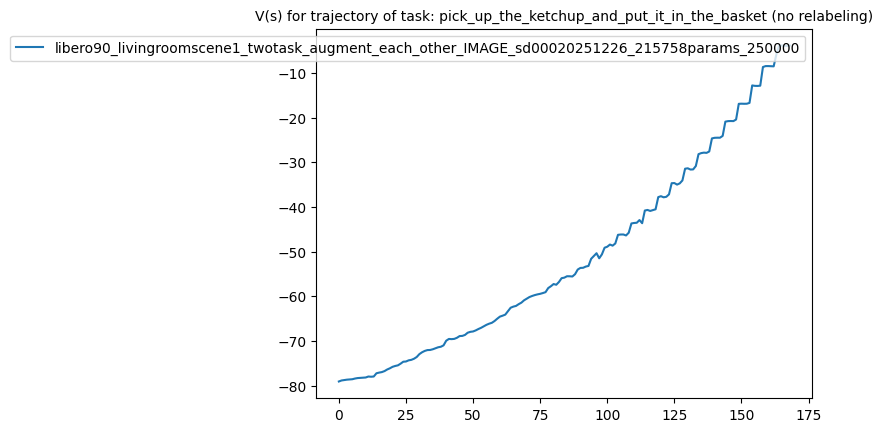

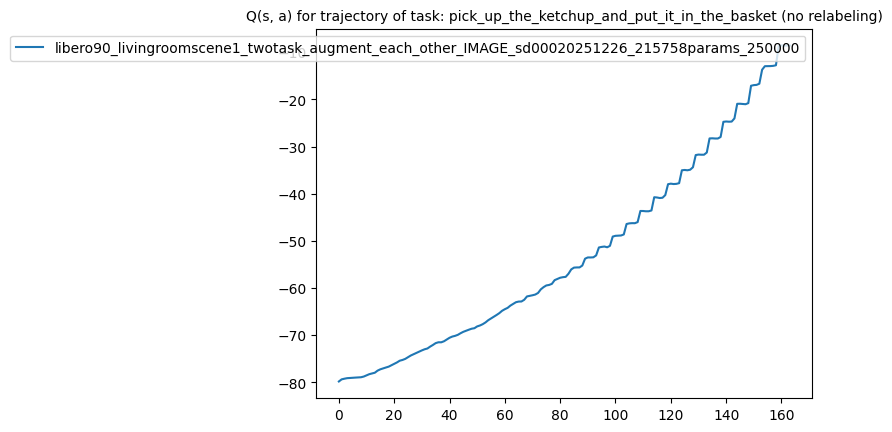

In [59]:
for label, agent in agents.items():
    print(f"plotting for {label}")
    plot_data = plot_Q_V_for_agent_augmented(agent)

    for (task_name, relabeled_task_name), data in plot_data.items():
        traj_state_values = data['traj_state_values']
        traj_q_values = data['traj_q_values']
        # plot traj_state_values
        plt.plot(traj_state_values, label=label)
        if task_name == relabeled_task_name:
            plt.title('V(s) for trajectory of task: ' + task_name + ' (no relabeling)', fontsize=10)
        else:
            plt.title('V(s) for trajectory of task: ' + task_name + ' relabeled as ' + relabeled_task_name, fontsize=10)
        plt.legend()
        plt.show()

        # plot traj_q_values
        plt.plot(traj_q_values, label=label)
        if task_name == relabeled_task_name:
            plt.title('Q(s, a) for trajectory of task: ' + task_name + ' (no relabeling)', fontsize=10)
        else:
            plt.title('Q(s, a) for trajectory of task: ' + task_name + ' relabeled as ' + relabeled_task_name, fontsize=10)
        plt.legend()
        plt.show()

In [ ]:
import jax
import jax.numpy as jnp

def plot_Q_heatmap_for_agent_augmented(agent):


    plot_data = {}

    task_lang_combos = []
    for task_name in task_to_datasets.keys():
        for task_name_other in task_to_datasets.keys():
            task_lang_combos.append((task_name, task_name_other))

    for task_name, relabeled_task_name in task_lang_combos:
        print(f"processing {task_name} and {relabeled_task_name}")
        train_dataset = task_to_datasets[task_name]
        traj_len = len(train_dataset['actions'])

        relabeled_task_dataset = task_to_datasets[relabeled_task_name]
        relabeled_task_sample_transition = relabeled_task_dataset.sample_sequence(1, sequence_length=5, discount=0.99, idxs_to_use=np.array([0,]))
        relabeled_task_lang_embedding = relabeled_task_sample_transition['observations']['language']

        train_dataset_sample_transition = train_dataset.sample_sequence(1, sequence_length=5, discount=0.99, idxs_to_use=np.array([0,]))
        train_dataset_lang_embedding = train_dataset_sample_transition['observations']['language']
        print(f"original_task_lang_embedding: 1 is at pos: {np.where(train_dataset_lang_embedding[0] == 1)}")
        print(f"relabeled_task_lang_embedding: 1 is at pos: {np.where(relabeled_task_lang_embedding[0] == 1)}")




        all_observations, all_actions = [], []
        for i in tqdm(range(traj_len - horizon_length)):
            for j in range(traj_len - horizon_length):
                transition_i = train_dataset.sample_sequence(1, sequence_length=5, discount=0.99, idxs_to_use=np.array([i,]))
                transition_j = train_dataset.sample_sequence(1, sequence_length=5, discount=0.99, idxs_to_use=np.array([j,]))

                actions_to_use = transition_j['actions']
                batch_actions = np.reshape(actions_to_use, (actions_to_use.shape[0], -1))


                obs = transition_i['observations']
                # relabel language instruction in obs!!
                obs['language'] = relabeled_task_lang_embedding
                
                act = batch_actions

                all_observations.append(obs)
                all_actions.append(act)
        
        print(f"stacking everything")
        stacked_obs = jax.tree_util.tree_map(lambda *xs: jnp.concatenate(xs, axis=0), *all_observations)
        stacked_acts = np.concatenate(all_actions, axis=0)

        def process_in_batches(agent, stacked_obs, stacked_acts, batch_size=256):
            total_size = jax.tree_util.tree_leaves(stacked_obs)[0].shape[0]
            num_batches = (total_size + batch_size - 1) // batch_size
            
            all_q_values = []        
            for start_idx in tqdm(range(0, total_size, batch_size), 
                                        total=num_batches, 
                                        desc="Computing Q-values"):
                end_idx = min(start_idx + batch_size, total_size)
                
                batch_obs = jax.tree_util.tree_map(lambda x: x[start_idx:end_idx], stacked_obs)
                batch_acts = stacked_acts[start_idx:end_idx]
                
                q1, q2 = agent.network.select('critic')(batch_obs, actions=batch_acts)
                q = jnp.minimum(q1, q2)
                
                all_q_values.append(q)
            
            return jnp.concatenate(all_q_values, axis=0)

        q_vals = process_in_batches(agent, stacked_obs, stacked_acts, batch_size=256)
        q_vals = q_vals.reshape(traj_len - horizon_length, traj_len - horizon_length)
        plot_data[(task_name, relabeled_task_name)] = q_vals
    
    
    return plot_data

plotting for libero90_livingroomscene1_singletask_none_augmentation_IMAGE_sd00020251226_214011params_125000
processing pick_up_the_alphabet_soup_and_put_it_in_the_basket and pick_up_the_alphabet_soup_and_put_it_in_the_basket
original_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], 1 is at pos: (array([12]),)
relabeled_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 148/148 [00:07<00:00, 18.61it/s]


stacking everything


Computing Q-values: 100%|██████████| 86/86 [00:06<00:00, 12.67it/s]


processing pick_up_the_alphabet_soup_and_put_it_in_the_basket and pick_up_the_ketchup_and_put_it_in_the_basket
original_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], 1 is at pos: (array([12]),)
relabeled_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], 1 is at pos: (array([43]),)


100%|██████████| 148/148 [00:08<00:00, 18.06it/s]


stacking everything


Computing Q-values: 100%|██████████| 86/86 [00:06<00:00, 12.58it/s]


processing pick_up_the_ketchup_and_put_it_in_the_basket and pick_up_the_alphabet_soup_and_put_it_in_the_basket
original_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], 1 is at pos: (array([43]),)
relabeled_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], 1 is at pos: (array([12]),)


100%|██████████| 164/164 [00:09<00:00, 16.77it/s]


stacking everything


Computing Q-values: 100%|██████████| 106/106 [00:08<00:00, 12.52it/s]


processing pick_up_the_ketchup_and_put_it_in_the_basket and pick_up_the_ketchup_and_put_it_in_the_basket
original_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], 1 is at pos: (array([43]),)
relabeled_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], 1 is at pos: (array([43]),)


100%|██████████| 164/164 [00:10<00:00, 16.37it/s]


stacking everything


Computing Q-values: 100%|██████████| 106/106 [00:08<00:00, 12.63it/s]
/tmp/ipykernel_214978/2937889123.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=10)


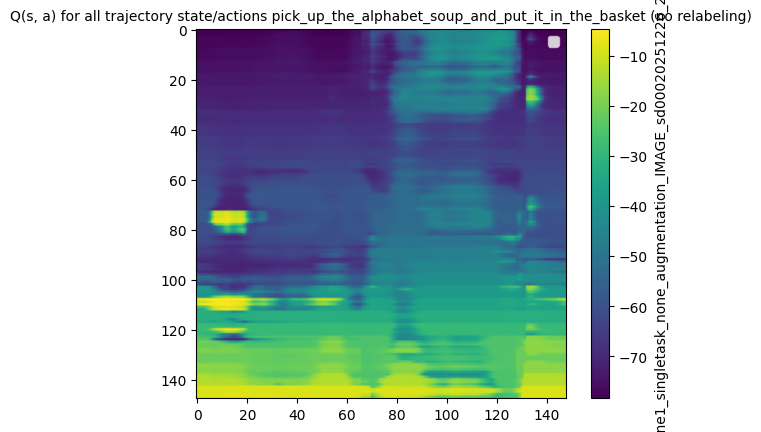

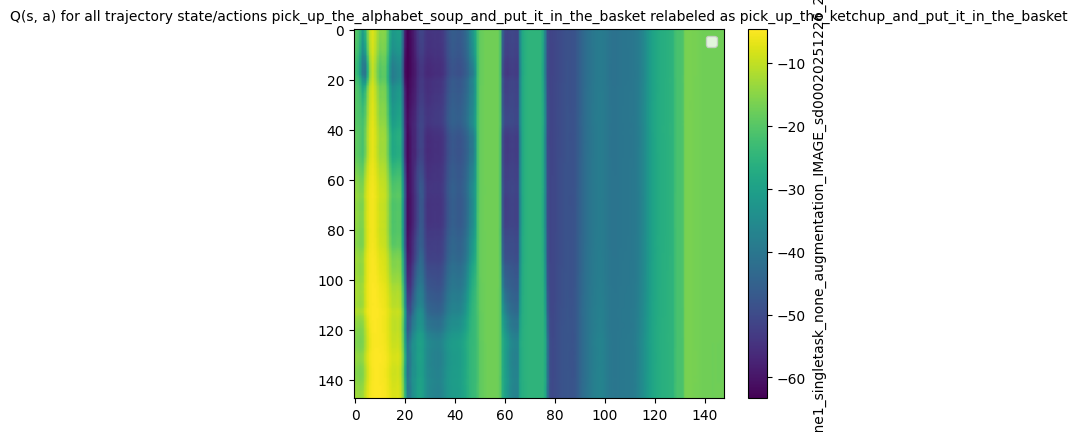

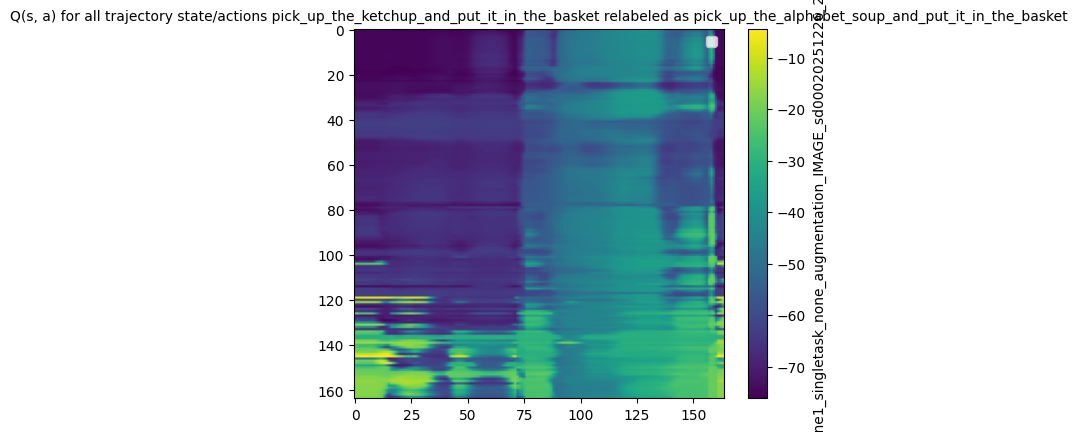

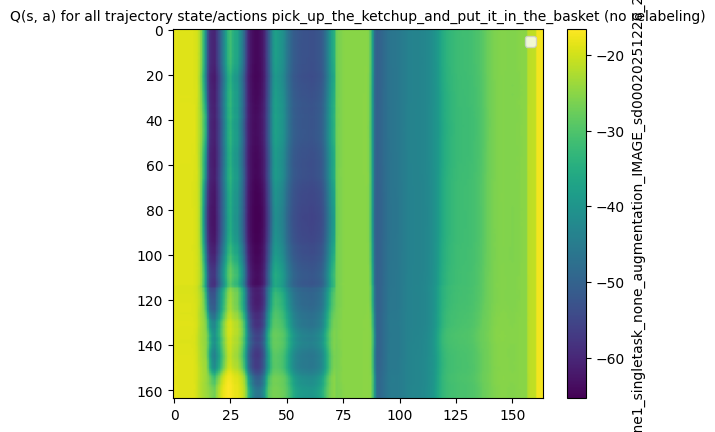

plotting for libero90_livingroomscene1_twotask_none_augmentation_IMAGE_sd00020251226_214200params_125000
processing pick_up_the_alphabet_soup_and_put_it_in_the_basket and pick_up_the_alphabet_soup_and_put_it_in_the_basket
original_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], 1 is at pos: (array([12]),)
relabeled_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 148/148 [00:07<00:00, 18.53it/s]


stacking everything


Computing Q-values: 100%|██████████| 86/86 [00:06<00:00, 12.56it/s]


processing pick_up_the_alphabet_soup_and_put_it_in_the_basket and pick_up_the_ketchup_and_put_it_in_the_basket
original_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], 1 is at pos: (array([12]),)
relabeled_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], 1 is at pos: (array([43]),)


100%|██████████| 148/148 [00:07<00:00, 18.57it/s]


stacking everything


Computing Q-values: 100%|██████████| 86/86 [00:06<00:00, 12.52it/s]


processing pick_up_the_ketchup_and_put_it_in_the_basket and pick_up_the_alphabet_soup_and_put_it_in_the_basket
original_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], 1 is at pos: (array([43]),)
relabeled_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], 1 is at pos: (array([12]),)


100%|██████████| 164/164 [00:09<00:00, 16.44it/s]


stacking everything


Computing Q-values: 100%|██████████| 106/106 [00:08<00:00, 12.57it/s]


processing pick_up_the_ketchup_and_put_it_in_the_basket and pick_up_the_ketchup_and_put_it_in_the_basket
original_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], 1 is at pos: (array([43]),)
relabeled_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], 1 is at pos: (array([43]),)


100%|██████████| 164/164 [00:09<00:00, 16.46it/s]


stacking everything


Computing Q-values: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s]


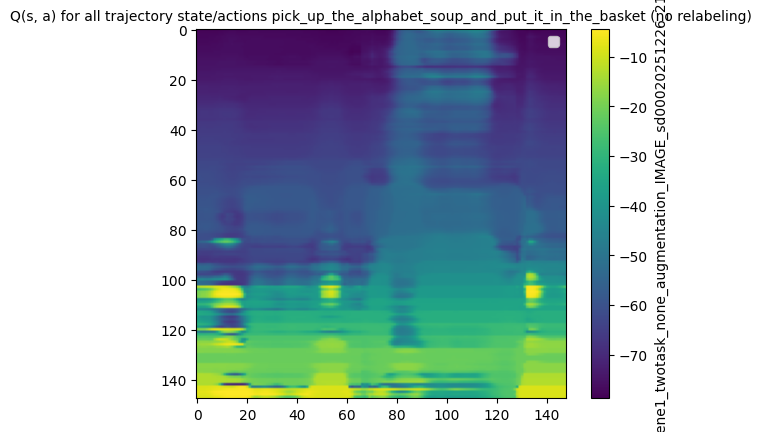

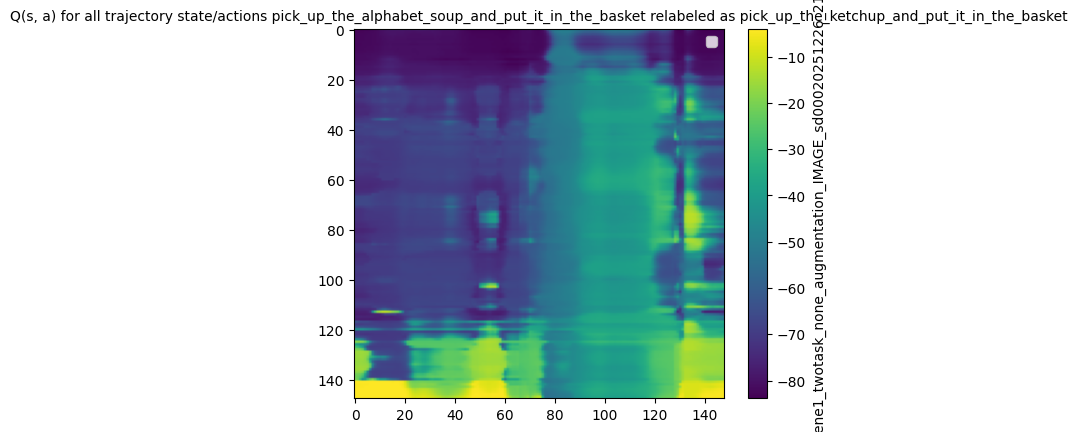

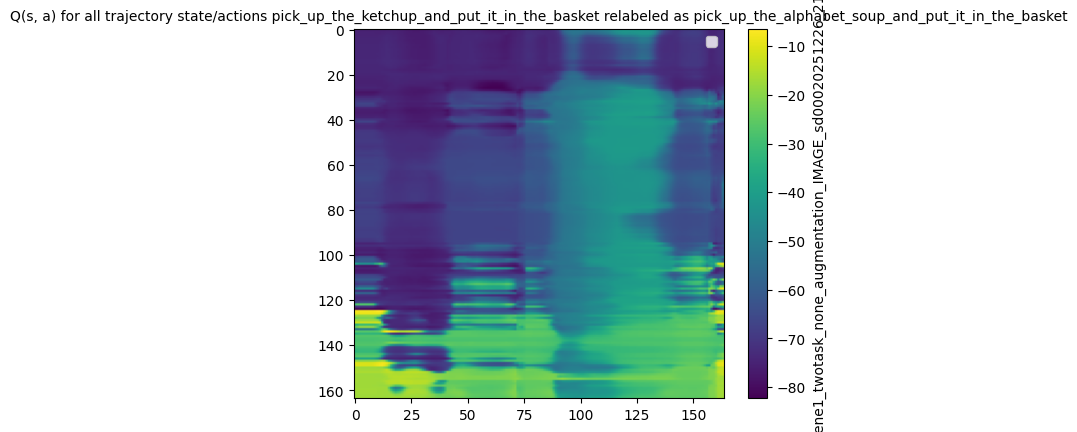

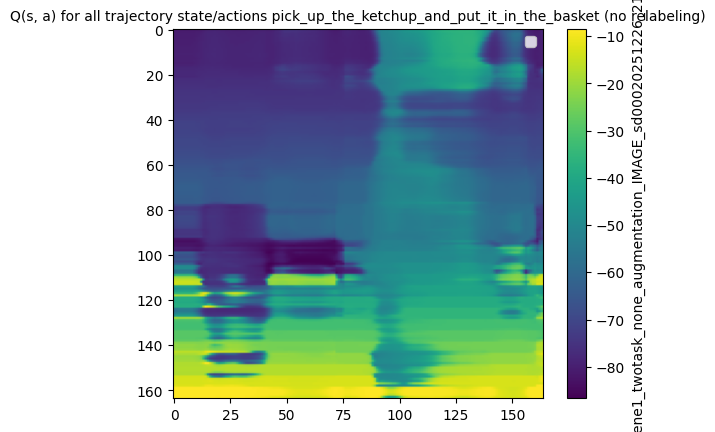

plotting for libero90_livingroomscene1_singletask_one_other_task__augmentation_IMAGE_sd00020251226_215816params_250000
processing pick_up_the_alphabet_soup_and_put_it_in_the_basket and pick_up_the_alphabet_soup_and_put_it_in_the_basket
original_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], 1 is at pos: (array([12]),)
relabeled_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 148/148 [00:08<00:00, 17.95it/s]


stacking everything


Computing Q-values: 100%|██████████| 86/86 [00:06<00:00, 12.76it/s]


processing pick_up_the_alphabet_soup_and_put_it_in_the_basket and pick_up_the_ketchup_and_put_it_in_the_basket
original_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], 1 is at pos: (array([12]),)
relabeled_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], 1 is at pos: (array([43]),)


100%|██████████| 148/148 [00:07<00:00, 18.94it/s]


stacking everything


Computing Q-values: 100%|██████████| 86/86 [00:06<00:00, 12.42it/s]


processing pick_up_the_ketchup_and_put_it_in_the_basket and pick_up_the_alphabet_soup_and_put_it_in_the_basket
original_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], 1 is at pos: (array([43]),)
relabeled_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], 1 is at pos: (array([12]),)


100%|██████████| 164/164 [00:10<00:00, 16.27it/s]


stacking everything


Computing Q-values: 100%|██████████| 106/106 [00:08<00:00, 12.54it/s]


processing pick_up_the_ketchup_and_put_it_in_the_basket and pick_up_the_ketchup_and_put_it_in_the_basket
original_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], 1 is at pos: (array([43]),)
relabeled_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], 1 is at pos: (array([43]),)


100%|██████████| 164/164 [00:09<00:00, 16.78it/s]


stacking everything


Computing Q-values: 100%|██████████| 106/106 [00:08<00:00, 11.81it/s]


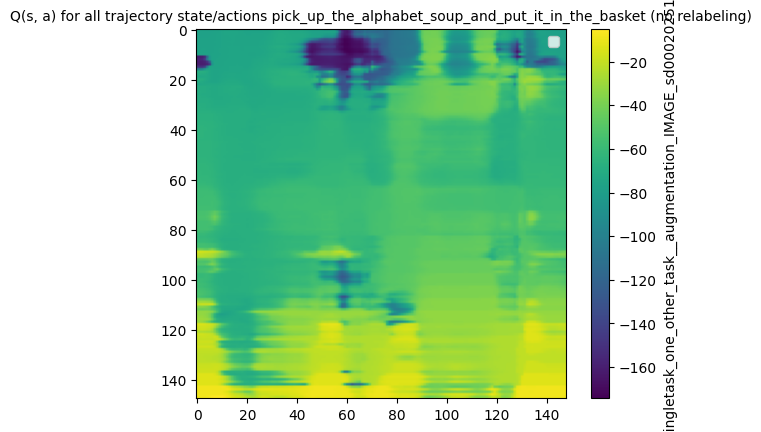

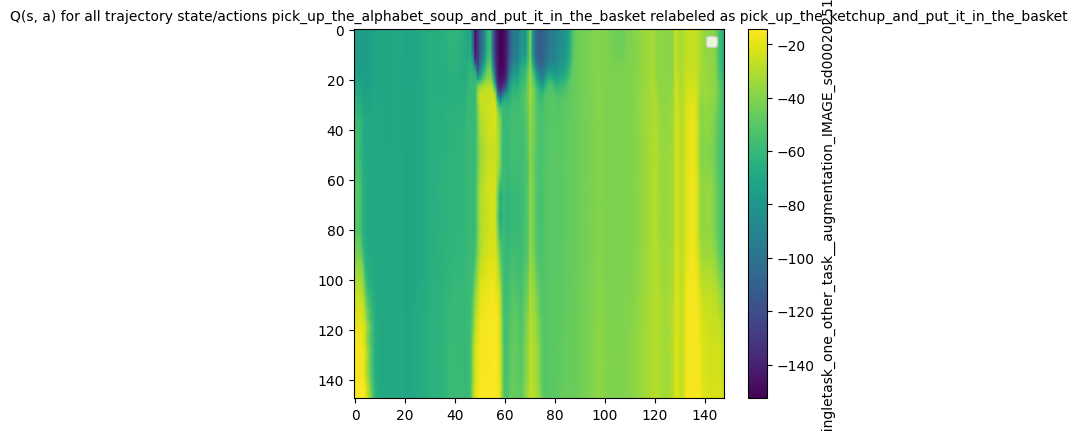

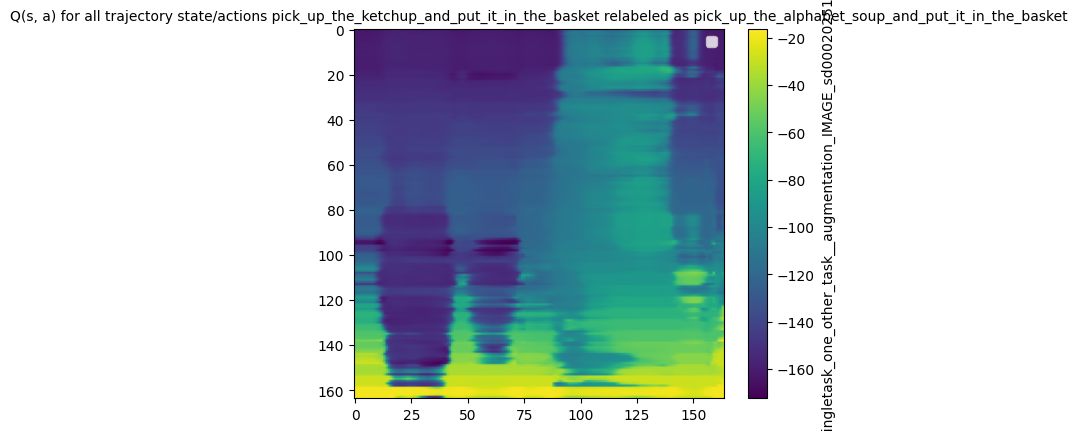

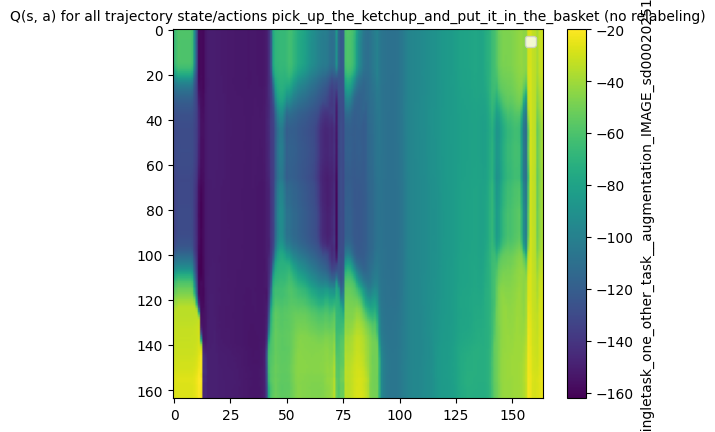

plotting for libero90_livingroomscene1_twotask_augment_each_other_IMAGE_sd00020251226_215758params_250000
processing pick_up_the_alphabet_soup_and_put_it_in_the_basket and pick_up_the_alphabet_soup_and_put_it_in_the_basket
original_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], 1 is at pos: (array([12]),)
relabeled_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 148/148 [00:07<00:00, 18.67it/s]


stacking everything


Computing Q-values: 100%|██████████| 86/86 [00:06<00:00, 12.63it/s]


processing pick_up_the_alphabet_soup_and_put_it_in_the_basket and pick_up_the_ketchup_and_put_it_in_the_basket
original_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], 1 is at pos: (array([12]),)
relabeled_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], 1 is at pos: (array([43]),)


100%|██████████| 148/148 [00:08<00:00, 18.16it/s]


stacking everything


Computing Q-values: 100%|██████████| 86/86 [00:06<00:00, 12.57it/s]


processing pick_up_the_ketchup_and_put_it_in_the_basket and pick_up_the_alphabet_soup_and_put_it_in_the_basket
original_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], 1 is at pos: (array([43]),)
relabeled_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], 1 is at pos: (array([12]),)


100%|██████████| 164/164 [00:09<00:00, 16.62it/s]


stacking everything


Computing Q-values: 100%|██████████| 106/106 [00:08<00:00, 12.64it/s]


processing pick_up_the_ketchup_and_put_it_in_the_basket and pick_up_the_ketchup_and_put_it_in_the_basket
original_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], 1 is at pos: (array([43]),)
relabeled_task_lang_embedding: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], 1 is at pos: (array([43]),)


100%|██████████| 164/164 [00:09<00:00, 16.59it/s]


stacking everything


Computing Q-values: 100%|██████████| 106/106 [00:08<00:00, 12.48it/s]


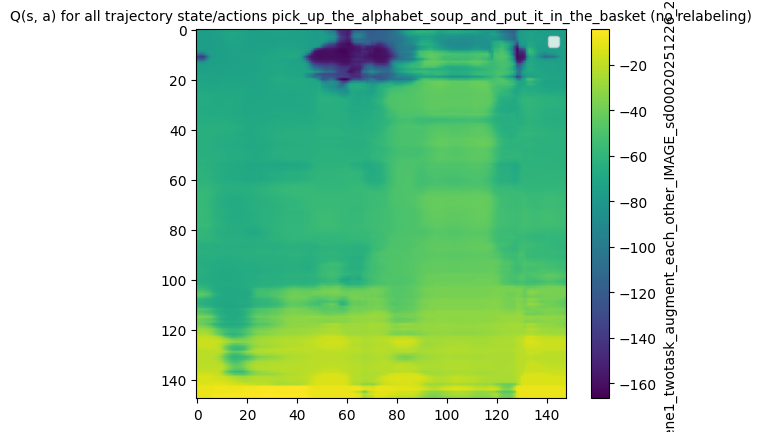

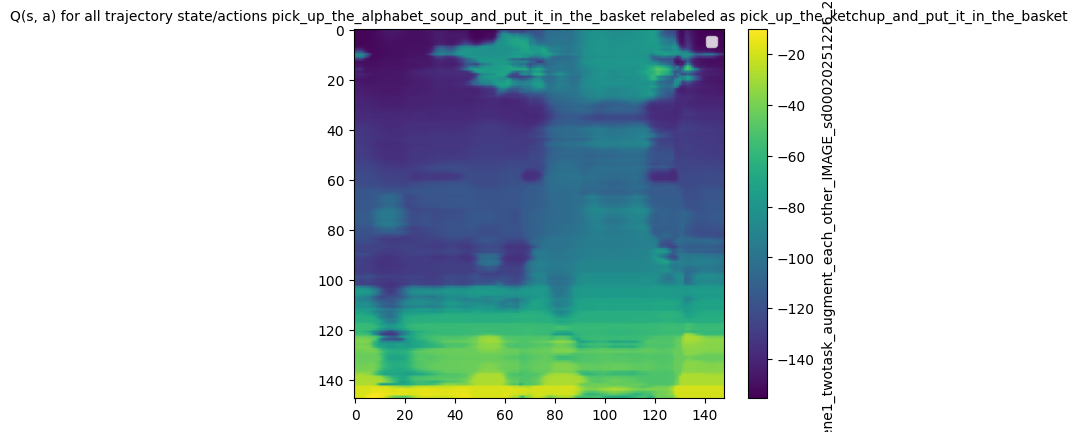

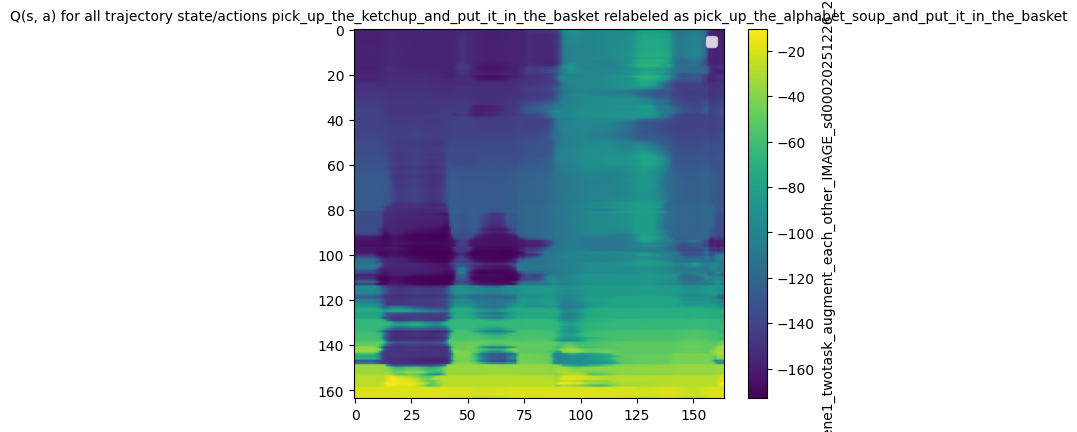

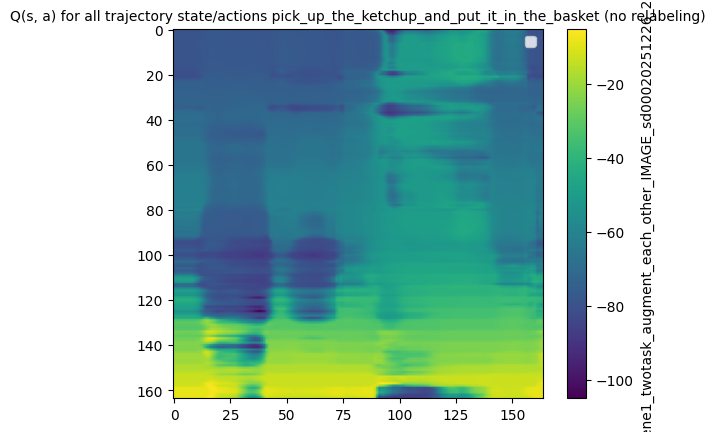

In [54]:
for label, agent in agents.items():
    print(f"plotting for {label}")
    plot_data = plot_Q_heatmap_for_agent_augmented(agent)

    for (task_name, relabeld_task_name), q_vals in plot_data.items():
        plt.imshow(q_vals)
        if task_name == relabeld_task_name:
            plt.title('Q(s, a) for all trajectory state/actions ' + task_name + ' (no relabeling)', fontsize=10)
        else:
            plt.title('Q(s, a) for all trajectory state/actions ' + task_name + ' relabeled as ' + relabeld_task_name, fontsize=10)
        
        plt.colorbar(label=label)
        plt.legend(fontsize=10)
        plt.show()

# Now Making Plots on Best-of-N Policy Rollouts